# FIGURE 2

In [1]:
import numpy as np
import pandas as pd
import math
from sklearn.cross_decomposition import PLSRegression
from sklearn.mixture import GaussianMixture
from sklearn.pipeline import Pipeline
from msresist.parameter_tuning import MSclusPLSR_tuning
from msresist.plsr import Q2Y_across_components, R2Y_across_components
from msresist.figures.figure2 import plotR2YQ2Y, plotMixedClusteringPLSR_GridSearch, plotMeasuredVsPredicted, plotScoresLoadings, plotclusteraverages
from msresist.clustering import MassSpecClustering
from msresist.sequence_analysis import preprocess_seqs, FormatName, pYmotifs
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from msresist.pre_processing import preprocessing, MergeDfbyMean, LinearFoldChange, FoldChangeToControl, MapOverlappingPeptides, BuildMatrix, TripsMeanAndStd, CorrCoefFilter
from msresist.FileExporter import create_download_link
import warnings
warnings.simplefilter("ignore")

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.mixture.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.mixture. Anything that cannot be imported from sklearn.mixture is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
# pd.set_option('display.max_colwidth', 1000)
# pd.set_option('display.max_rows', 1000)
# pd.set_option('display.max_columns', 1000)

### Importing and Pre-processing Data

### Phosphorylation measurements:

In [3]:
ABC = preprocessing(AXLwt=True, motifs=True, Vfilter=True, FCfilter=True, log2T=True, mc_row=True)
ABC = preprocess_seqs(ABC, "Y").sort_values(by="Protein")

header = ABC.columns
treatments = ABC.columns[7:]

data = ABC.iloc[:, 7:].T
info = ABC.iloc[:, :7]

### Phenotypes

#### Cell Viability:

In [4]:
Y_cv1 = pd.read_csv('./msresist/data/Phenotypic_data/CV_raw3.csv').iloc[:30, :11]
Y_cv2 = pd.read_csv('./msresist/data/Phenotypic_data/CV_raw4.csv').iloc[:29, :11]

for ii in range(1, Y_cv2.columns.size):
    Y_cv1.iloc[:, ii] /= Y_cv1.iloc[0, ii]
    Y_cv2.iloc[:, ii] /= Y_cv2.iloc[0, ii]

Y_cv = MergeDfbyMean(pd.concat([Y_cv1, Y_cv2], axis=0), Y_cv1.columns, "Elapsed")
Y_cv = Y_cv.reset_index()[Y_cv1.columns]
Y_cv = Y_cv[Y_cv["Elapsed"] == 72].iloc[0, 1:]

# Chained MS mixed clustering + PLSR analysis

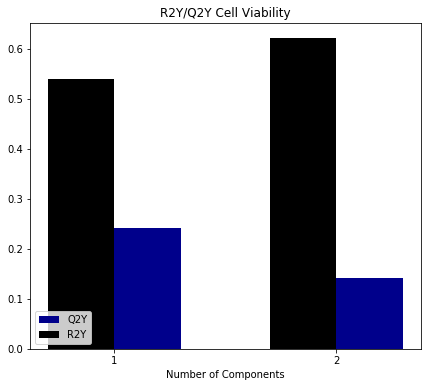

In [5]:
distance_method = "Binomial"
ncl = 2
GMMweight = 0

MSC = MassSpecClustering(info, ncl, GMMweight=GMMweight, distance_method=distance_method).fit(data, Y_cv)
centers = MSC.transform(data)

fig, ax = plt.subplots(1, 1, figsize=(7,6))
plotR2YQ2Y(ax, ncl, centers, Y_cv)

In [6]:
# fig, ax = plt.subplots(1, 1, figsize=(8,6))
# plotMixedClusteringPLSR_GridSearch(ax, data, info, Y_cv)

In [7]:
ncomp = 2

mixedCl_plsr = Pipeline([('mixedCl', MassSpecClustering(info, ncl, GMMweight=GMMweight, distance_method=distance_method)), ('plsr', PLSRegression(ncomp))])
fit = mixedCl_plsr.fit(data, Y_cv)

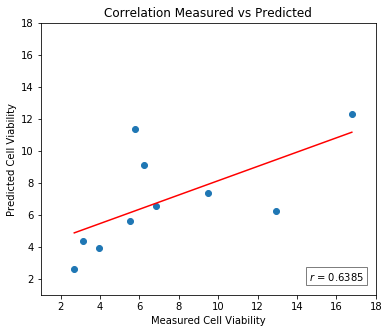

In [8]:
fig, ax = plt.subplots(1,1,figsize=(6,5))
plotMeasuredVsPredicted(ax, mixedCl_plsr, data, Y_cv)

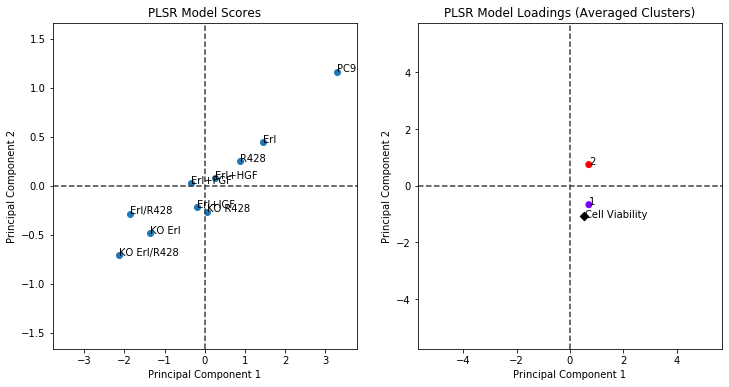

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))

plotScoresLoadings(ax, fit, centers, Y_cv, ncl, treatments)

In [10]:
clustermembers = mixedCl_plsr.named_steps.mixedCl.clustermembers(ABC.T)
clustermembers.iloc[:10, :]

,Prot_C1,abbv_C1,seqs_C1,UniprotAcc_C1,Pos_C1,r2/Std_C1,BioReps_C1,Prot_C2,abbv_C2,seqs_C2,UniprotAcc_C2,Pos_C2,r2/Std_C2,BioReps_C2
0,"1-phosphatidylinositol 4,5-bisphosphate phosph...",Y783-p,RNPGFyVEANP,P19174,PLCG1,1,N/A,14-3-3 protein epsilon,Y131-p,GDYHRyLAEFA,P62258,YWHAE,1,N/A
1,14-3-3 protein zeta/delta,Y48-p,LLSVAyKNVVG,P63104,YWHAZ,1,N/A,60S ribosomal protein L22-like 1,Y108-p,TYELRyFQISQ,Q6P5R6,RPL22L1,1,N/A
2,ARF GTPase-activating protein GIT1,Y383-p,DDQHDyDSVAS,Q9Y2X7,GIT1,1,N/A,ADP-ribosylation factor-like protein 11,Y30-p,KtTLLyKLKGH,Q969Q4,ARL11,2,0.94
3,ATPase WRNIP1,Y500-p,AGEEHyNCISA,Q96S55,WRNIP1,1,N/A,ADP/ATP translocase 2,Y81-p,ANVIRyFPTQA,P05141,SLC25A5,1,N/A
4,Abl interactor 2,Y213-p,VVPNDyVPSPT,Q9NYB9,ABI2,1,N/A,ARF GTPase-activating protein GIT1,Y598-p,GADSDyENTQS,Q9Y2X7,GIT1,1,N/A
5,Actin filament-associated protein 1-like 2,Y56-p,DEEYIyMNKVT,Q8N4X5,AFAP1L2,1,N/A,Actin filament-associated protein 1-like 2,Y413-p,SPDHLySFRIL,Q8N4X5,AFAP1L2,1,N/A
6,Actin-related protein 3,Y109-p,EPEDHyFLLTE,P61158,ACTR3,1,N/A,"Actin, cytoplasmic 1",Y188-p,RDLTDyLMKIL,P60709,ACTB,2,0.96
7,Activated CDC42 kinase 1,Y859-p,VSSTHyYLLPE,Q07912,TNK2,1,N/A,Activator of 90 kDa heat shock protein ATPase ...,Y322-p,QGWQRyYFEGI,O95433,AHSA1,2,0.93
8,Adapter molecule crk,Y136-p,QEEAEyVRALF,P46108,CRK,2,0.85,Aldo-keto reductase family 1 member B1,Y40-p,AIDVGyRHIDC,P15121,AKR1B1,1,N/A
9,"Adenylate kinase 2, mitochondrial",Y12-p,AAEPEyPKGIR,P54819,AK2,1,N/A,Alpha-actinin-1,Y708-p,NKHTNyTMEHI,P12814,ACTN1,1,N/A


In [11]:
create_download_link(clustermembers, "DataClustering")

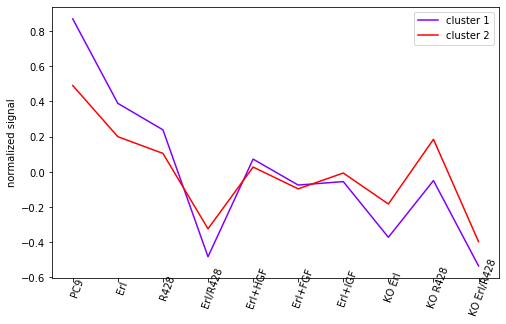

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

plotclusteraverages(ax, ABC, mixedCl_plsr, ncl)